In [78]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [80]:
data_path = './data/'

train_ds = torchvision.datasets.FashionMNIST(data_path, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_ds = torchvision.datasets.FashionMNIST(data_path, download=True, train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)

In [81]:
# DataLoader
# batch size 지정, data shuffle

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=100)    # 어떤 데이터를 불러올지 지정하고, batch_size 지정
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=100)

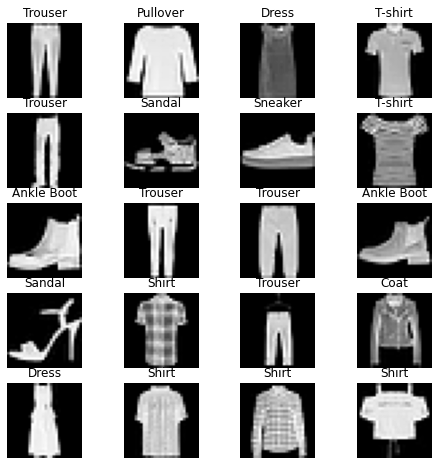

In [82]:
label = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
cols = 4
rows = 5

for i in range(1, cols*rows +1):
    img_xy = np.random.randint(len(train_ds))
    img = train_ds[img_xy][0][0]                # train_ds[n][0][0] - image array 값 저장되어 있음 (img siez = 28 * 28)
    fig.add_subplot(rows, cols, i)
    plt.title(label[train_ds[img_xy][1]])       # train_ds[n][1] - 레이블 저장되어 있음
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [83]:
# DNN 모델 생성

class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        # out = F.log_softmax(out, dim=1)
        return out

In [84]:
# 하이퍼파라미터 정의

lr = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [85]:
# 모델 학습

epochs = 5
count = 0

loss_list = []
iteration_list = []
acc_list = []
pred_list = []
label_list = []

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                label_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_list.append(pred)
                correct += (pred == labels).sum()
                total += len(labels)

            acc = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(acc)
        
        if not (count % 500):
            print(f'Iteration: {count}, Loss: {loss.data}, Acc: {acc}%')

Iteration: 500, Loss: 0.5933910608291626, Acc: 83.62000274658203%
Iteration: 1000, Loss: 0.5113154649734497, Acc: 84.52999877929688%
Iteration: 1500, Loss: 0.34705325961112976, Acc: 84.3499984741211%
Iteration: 2000, Loss: 0.3716089129447937, Acc: 85.3499984741211%
Iteration: 2500, Loss: 0.22329983115196228, Acc: 86.33999633789062%
Iteration: 3000, Loss: 0.25454428791999817, Acc: 87.12000274658203%


In [86]:
pred_list

[tensor([9, 2, 1, 1, 6, 1, 6, 4, 7, 7, 2, 9, 8, 3, 4, 1, 2, 6, 8, 0, 6, 7, 7, 7,
         1, 4, 4, 3, 9, 3, 8, 8, 3, 3, 8, 0, 7, 7, 7, 9, 0, 1, 3, 9, 6, 9, 6, 1,
         4, 4, 6, 2, 7, 8, 4, 6, 8, 2, 8, 0, 7, 7, 8, 5, 1, 1, 3, 1, 9, 8, 7, 0,
         6, 3, 4, 3, 1, 2, 8, 2, 1, 8, 5, 9, 5, 0, 3, 6, 0, 2, 5, 3, 4, 7, 1, 8,
         0, 1, 6, 2]),
 tensor([3, 4, 7, 4, 7, 8, 7, 9, 9, 4, 2, 7, 7, 0, 5, 2, 8, 6, 7, 8, 0, 0, 9, 9,
         3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 4, 6, 1, 4, 5, 1, 0, 0, 0, 1, 6, 1, 3,
         6, 6, 4, 6, 1, 3, 7, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 9, 4, 6, 0, 7,
         4, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 8, 7, 9, 9, 4, 4, 7, 3, 2, 3, 6, 3, 2,
         8, 3, 6, 1]),
 tensor([1, 0, 4, 9, 4, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 3, 2, 7, 4, 8, 9, 6, 0,
         7, 7, 0, 6, 7, 0, 7, 8, 9, 2, 9, 0, 9, 1, 4, 2, 5, 8, 9, 4, 4, 8, 4, 4,
         6, 4, 9, 7, 3, 7, 9, 4, 8, 5, 2, 3, 0, 4, 8, 0, 0, 4, 3, 8, 9, 0, 1, 6,
         0, 4, 3, 0, 8, 3, 7, 4, 0, 1, 6, 1, 0, 6, 0, 7, 5, 3, 

In [74]:
train_loader